In [29]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import math
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('heart.csv').set_index('HeartDisease').reset_index().rename(columns={'FastingBS':'FastingBS_Above120'})
df.head()

,HeartDisease,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS_Above120,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,0,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,1,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,0,54,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HeartDisease        918 non-null    int64  
 1   Age                 918 non-null    int64  
 2   Sex                 918 non-null    object 
 3   ChestPainType       918 non-null    object 
 4   RestingBP           918 non-null    int64  
 5   Cholesterol         918 non-null    int64  
 6   FastingBS_Above120  918 non-null    int64  
 7   RestingECG          918 non-null    object 
 8   MaxHR               918 non-null    int64  
 9   ExerciseAngina      918 non-null    object 
 10  Oldpeak             918 non-null    float64
 11  ST_Slope            918 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# Visual analysis
## CATEGORICAL FEATURES HISTOGRAM

In [5]:
def histogram(data, columns, equal_scales=True, title='Histogram'):
    fig, axs = plt.subplots(1, len(columns), figsize=(20, 7))
    y_lim =  data[columns].apply(pd.value_counts).max().max()*1.05
    i = 0
    for col in columns:
        g = sns.histplot(data=data, x=col, ax=axs[i], multiple='dodge', shrink=0.9)
        i+=1
        if(equal_scales):
            g.set(ylim=(0,y_lim))
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

def separate_histogram(data, columns, equal_scales=True, title='Layered Histogram split by HeartDisease', kde=False):
    fig, axs = plt.subplots(1, len(columns), figsize=(20, 7))
    y_lim = 0
    for val in data['HeartDisease'].unique():
        y_lim = max(y_lim, data[data['HeartDisease']==val][columns].apply(pd.value_counts).max().max()) * 1.05
    i = 0
    for col in columns:
        g = sns.histplot(data=data, x=col, ax=axs[i], hue='HeartDisease', multiple='layer', shrink=0.9, kde=kde, line_kws={'lw': 4})
        i+=1
        if(equal_scales):
            g.set(ylim=(0,y_lim))
        
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

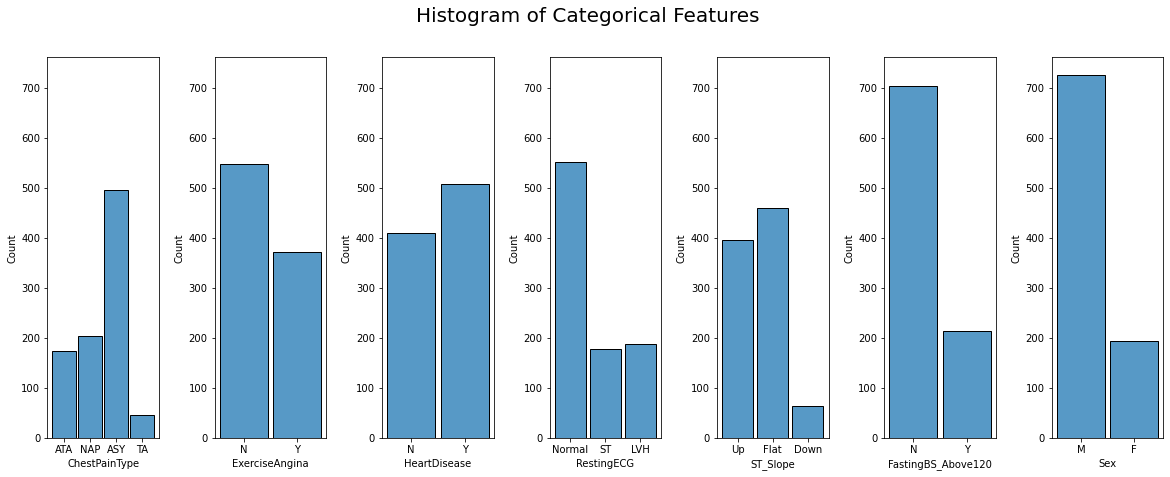

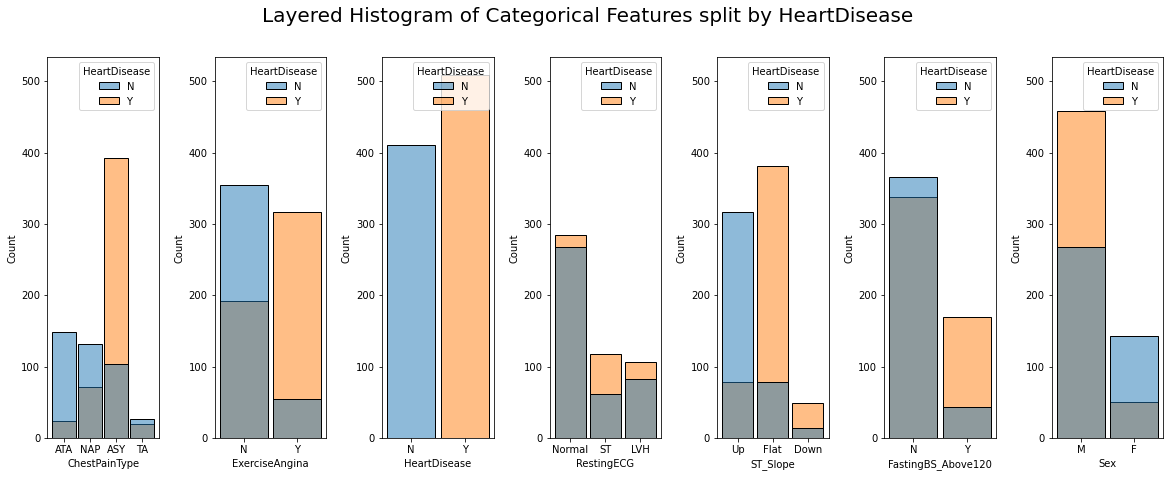

In [6]:
# Categorical columns (non-numeric OR only 2 values)
ohe_cols = (df.dtypes=='object')
ohe_cols = ohe_cols[ohe_cols].index.tolist()
bin_cols = (df.nunique()==2)
bin_cols = bin_cols[bin_cols].index.tolist()
histogram(df.replace({0: 'N', 1:'Y'}), set(ohe_cols+bin_cols), title='Histogram of Categorical Features')
separate_histogram(df.replace({0: 'N', 1:'Y'}), list(set(ohe_cols+bin_cols)), title='Layered Histogram of Categorical Features split by HeartDisease')

Sex and FastingBS_above120 are clearly imbalanced.

Certain others seem somewhat imbalaced:
- RestingECG (Normal $\approx$ ST + LVH)
- ST_Slope (Down largly under-represented)
- ChestPainType (TA largly under-represented)

## CONTINUOUS FEATURES BOXPLOT

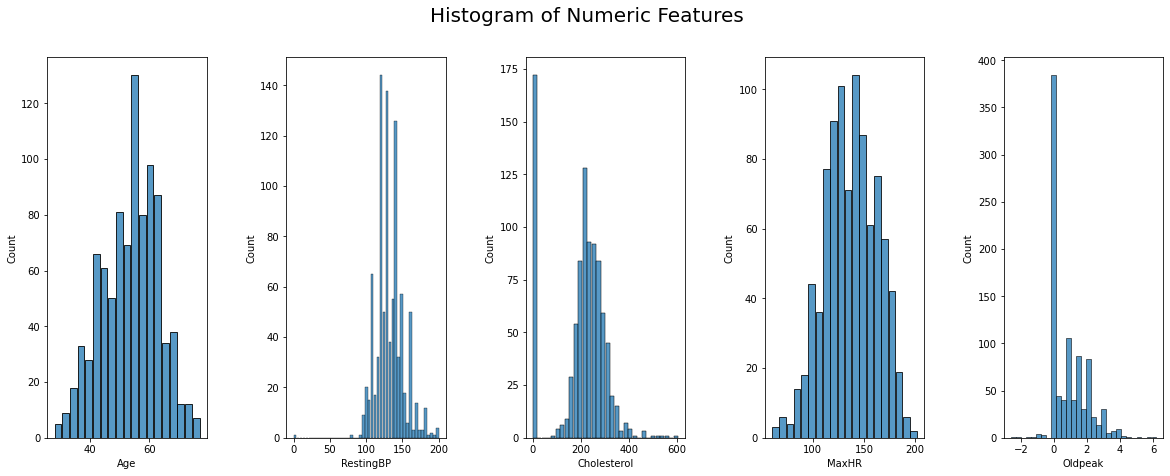

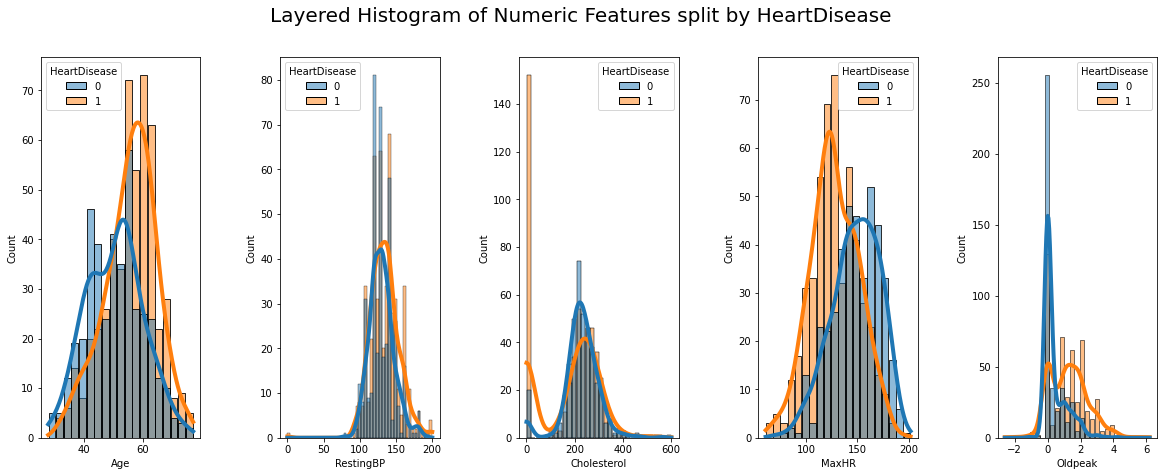

In [7]:
non_bin =df.drop(columns=ohe_cols+bin_cols+['HeartDisease'])
selection = non_bin.columns.tolist()
histogram(df, selection, equal_scales=False, title='Histogram of Numeric Features')
separate_histogram(df, selection, equal_scales=False, kde=True, title = 'Layered Histogram of Numeric Features split by HeartDisease')

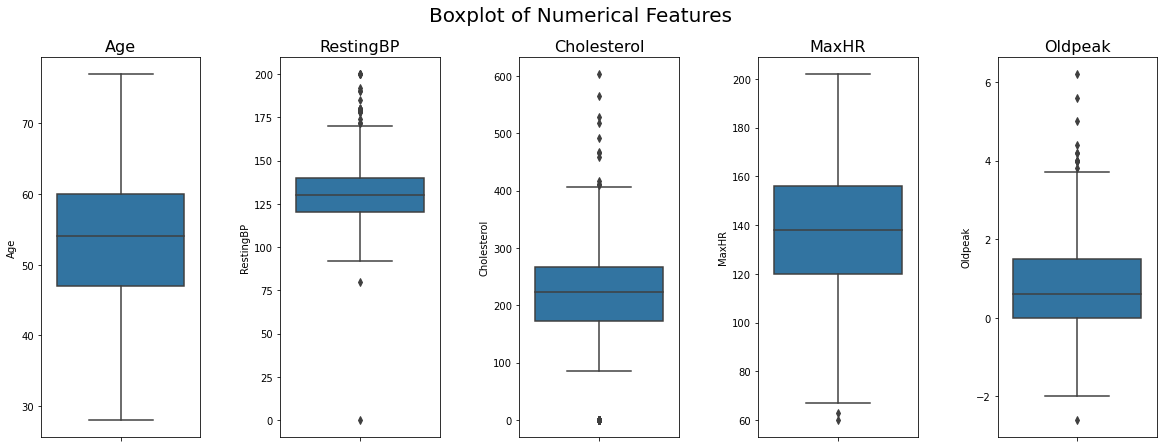

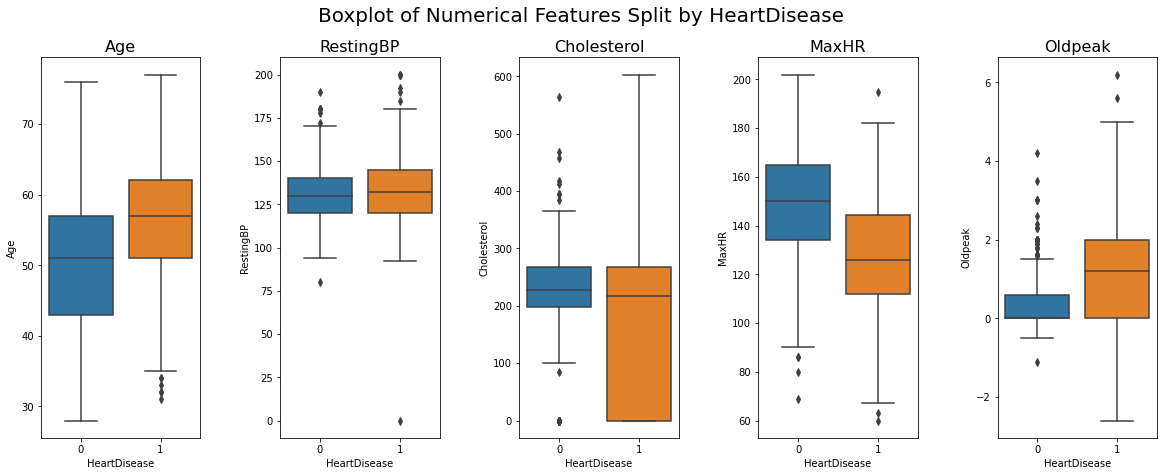

In [8]:
def boxplot(data, columns,  title='Boxplot of Numerical Features'):

    fig, axs = plt.subplots(1, len(selection), figsize=(20, 7))
    i=0
    for col in columns:
        g= sns.boxplot(data=data, y=col, ax=axs[i])
        axs[i].set_title(col, fontsize=16)
        i+=1
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

def separate_boxplot(data, columns, title='Boxplot of Numerical Features Split by HeartDisease'):
    fig, axs = plt.subplots(1, len(selection), figsize=(20, 7))
    i=0
    for col in columns:
        g= sns.boxplot(data=data,x='HeartDisease', y=col, ax=axs[i])
        axs[i].set_title(col, fontsize=16)
        i+=1
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()
    
boxplot(df, selection)
separate_boxplot(df, selection)

RestingBP and Cholesterol = 0 error: remove  
Outliers outside IQR: remove?

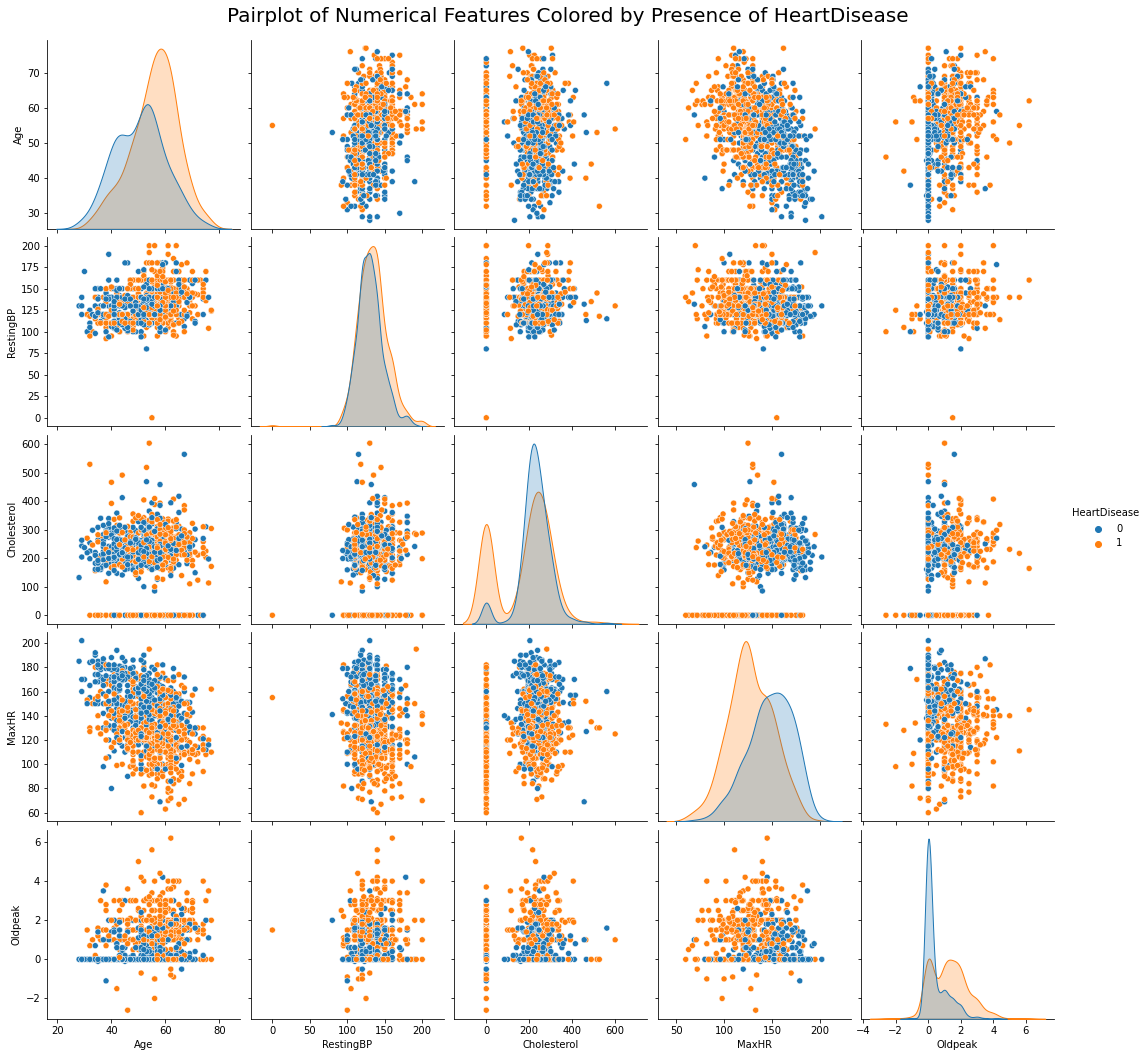

In [9]:
def pairplot(data, columns, title='Pairplot of Numerical Features Colored by Presence of HeartDisease'):
    pairplot = sns.pairplot(data[columns], hue="HeartDisease", height=3)
    pairplot.fig.subplots_adjust(top=0.95)
    pairplot.fig.suptitle(title, fontsize=20, fontweight=2)
pairplot(df, selection+['HeartDisease'])

# PREPARE DATASET: 
#### 1. Remove errors
    - Cholesteral and RestingBP = 0 is impossible

In [12]:
dropped = df[(df['Cholesterol'] == 0) & (df['Cholesterol'] == 0)]
cleaned = df.drop(dropped.index)
print('Dropped {} rows.\nKept {} rows.'.format(len(dropped), len(cleaned)))

Dropped 172 rows.
Kept 746 rows.


#### 2. OHE and Binary to (0, 1):
    - Sex (M or F), ExerciseAngine (N or Y), FastingBS_120+ (0 or 1) are binary -> 0, 1
    - ChestPainType, ST_Slope and RestingECG are categorical -> One Hot Encoding
   

In [13]:
prepared = cleaned.copy(deep=True)

bin_cols = ['Sex', 'ExerciseAngina', 'FastingBS_Above120']
prepared[bin_cols] = prepared[bin_cols].replace({'M':0, 'F':1, 'N' : 0, 'Y':1})

ohe_cols = ['ChestPainType','ST_Slope', 'RestingECG']
prepared = pd.get_dummies(prepared, columns=ohe_cols, prefix_sep='__')
prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HeartDisease        746 non-null    int64  
 1   Age                 746 non-null    int64  
 2   Sex                 746 non-null    int64  
 3   RestingBP           746 non-null    int64  
 4   Cholesterol         746 non-null    int64  
 5   FastingBS_Above120  746 non-null    int64  
 6   MaxHR               746 non-null    int64  
 7   ExerciseAngina      746 non-null    int64  
 8   Oldpeak             746 non-null    float64
 9   ChestPainType__ASY  746 non-null    uint8  
 10  ChestPainType__ATA  746 non-null    uint8  
 11  ChestPainType__NAP  746 non-null    uint8  
 12  ChestPainType__TA   746 non-null    uint8  
 13  ST_Slope__Down      746 non-null    uint8  
 14  ST_Slope__Flat      746 non-null    uint8  
 15  ST_Slope__Up        746 non-null    uint8  
 16  RestingE

#### 3. Standardize continuous columns
    - Age, RestingBP, Cholesterol, MaxHR, OldPeak

In [14]:
continuous_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
prepared[continuous_cols] = StandardScaler().fit_transform(prepared[continuous_cols])

#### 4. Remove outliers
    Outside of IQR, after standardization: <= -3 and >= 3

In [15]:
prepared = prepared[(prepared.abs()<3).all(axis=1)]
print('Kept {} rows.'.format(len(prepared)))

Kept 727 rows.


# Numerical Analysis
#### 1. Collinearity

In [16]:
correlation = prepared.corr()

def correlated(row, threshold):
    cor = row[row>threshold].index.tolist()
    cor.remove(row.name)
    return cor
correlation['high_cor'] = correlation.apply(correlated, threshold=0.8, axis=1)
correlation['high_cor']

HeartDisease          []
Age                   []
Sex                   []
RestingBP             []
Cholesterol           []
FastingBS_Above120    []
MaxHR                 []
ExerciseAngina        []
Oldpeak               []
ChestPainType__ASY    []
ChestPainType__ATA    []
ChestPainType__NAP    []
ChestPainType__TA     []
ST_Slope__Down        []
ST_Slope__Flat        []
ST_Slope__Up          []
RestingECG__LVH       []
RestingECG__Normal    []
RestingECG__ST        []
Name: high_cor, dtype: object

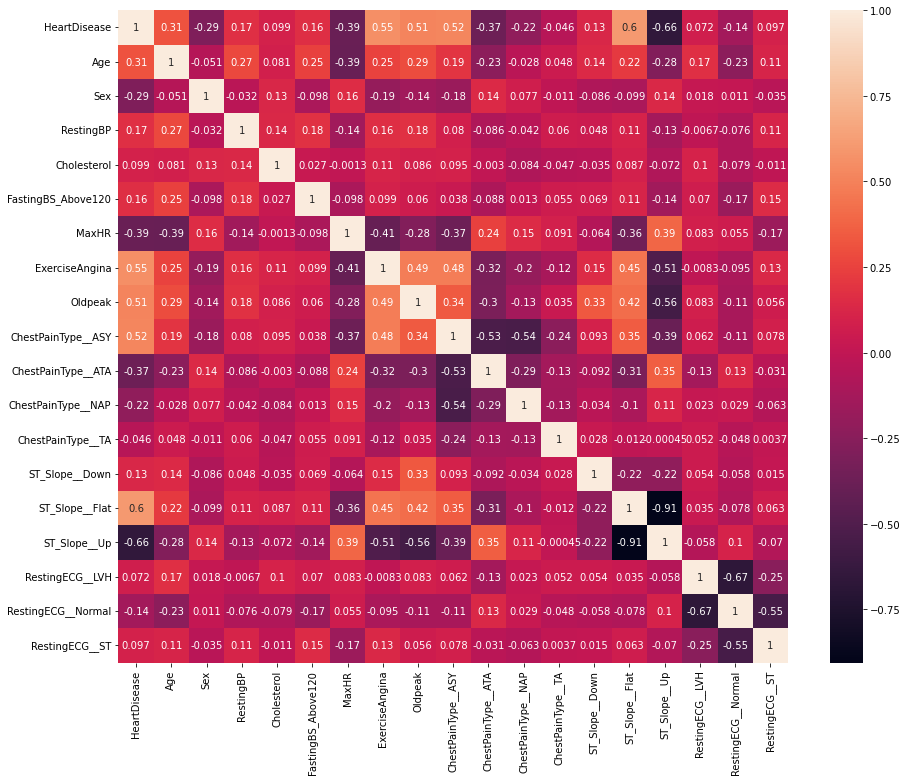

In [17]:
plt.figure(figsize=(15, 12))
sns.heatmap(prepared.corr(),  annot=True)
plt.show()

#### 2. Statistical difference test
##### 2 Tailed T-Test:
- Compare population means
- Assume no equal variances between population (look into this)
- $H_{0}$ : $\mu_{i, heartdisease} = \mu_{i, no\_heartdisease}$
- $H_{a}$ : $\mu_{i, heartdisease} \neq \mu_{i, no\_heartdisease}$  
where i $\in$ ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [14]:
significantly_different = []

def ind_t_test(column, group, data):

    group0 = data[data[group]==0][column]
    group1 = data[data[group]==1][column]
    
    print(column,':')
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    reject = p_val<significance_level
    print('\t-{} {} vs {} {} => p-value: {:.2E}, t statistic: {:.5f}'.format(group, 0, group, 1, p_val, t_stat))
    if reject:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different'.format(p_val, '<', significance_level, 'rejected', ''))
    else:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different.'.format(p_val, '>', significance_level, 'accepted', 'not'))
    print()
    return reject

significance_level = 0.05
for col in continuous_cols:
    if(ind_t_test(col, 'HeartDisease', prepared)):
        significantly_different.append(col)

Age :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 9.84E-18, t statistic: -8.80212
	 9.84E-18 < 0.05. H0 is rejected. Both populations are  significantly different

RestingBP :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 6.14E-06, t statistic: -4.55634
	 6.14E-06 < 0.05. H0 is rejected. Both populations are  significantly different

Cholesterol :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 7.76E-03, t statistic: -2.66987
	 7.76E-03 < 0.05. H0 is rejected. Both populations are  significantly different

MaxHR :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 4.18E-28, t statistic: 11.47558
	 4.18E-28 < 0.05. H0 is rejected. Both populations are  significantly different

Oldpeak :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 9.90E-46, t statistic: -15.60256
	 9.90E-46 < 0.05. H0 is rejected. Both populations are  significantly different



##### Chi-Squared tests:
- Compare heart disease proportions between populations
- $H_0$: i is indepent to HeartDisease
- $H_a$: i is depent to HeartDisease  
where i $\in$ ['Sex', 'FastingBS_120+', 'ExerciseAngina', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST']


In [15]:
def ind_chi2_test(column, group, data):
    contigency = pd.crosstab(prepared[col], prepared[group])
    chi2, p_val, dof, expected = stats.chi2_contingency(contigency) 
    reject = p_val<significance_level
    
    print(column,':')
    print('\t-{} {} vs {} {} => p-value: {:.2E}, Chi-Square value: {:.5f}'.format(group, data[group].unique()[0], group, data[group].unique()[1], p_val, chi2))
    if reject:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different'.format(p_val, '<', significance_level, 'rejected', ''))
    else:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different.'.format(p_val, '>', significance_level, 'accepted', 'not'))
    print()
    return reject

significance_level = 0.05
for col in prepared.drop(columns=continuous_cols+['HeartDisease']):
    if(ind_chi2_test(col, 'HeartDisease', prepared)):
        significantly_different.append(col)

Sex :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.41E-15, Chi-Square value: 61.10694
	 5.41E-15 < 0.05. H0 is rejected. Both populations are  significantly different

FastingBS_Above120 :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 2.52E-05, Chi-Square value: 17.75017
	 2.52E-05 < 0.05. H0 is rejected. Both populations are  significantly different

ExerciseAngina :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 6.02E-50, Chi-Square value: 220.81197
	 6.02E-50 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType__ASY :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.82E-44, Chi-Square value: 193.37761
	 5.82E-44 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType__ATA :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 1.39E-23, Chi-Square value: 100.18565
	 1.39E-23 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType__NAP :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.22E-09, Chi

In [16]:
significantly_different.sort()
print(significantly_different)

['Age', 'ChestPainType__ASY', 'ChestPainType__ATA', 'ChestPainType__NAP', 'Cholesterol', 'ExerciseAngina', 'FastingBS_Above120', 'MaxHR', 'Oldpeak', 'RestingBP', 'RestingECG__Normal', 'RestingECG__ST', 'ST_Slope__Down', 'ST_Slope__Flat', 'ST_Slope__Up', 'Sex']


# Partial Dependence Plots

In [20]:
from sklearn.model_selection import train_test_split
y = prepared['HeartDisease']
x = prepared.drop('HeartDisease', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.inspection import plot_partial_dependence

for i in range(len(x_train.columns)):
    plot_partial_dependence(model, x_train, [i])
    plt.xlabel(x.columns[i] + ' -- ')
    plt.ylabel('Probability (heart disease = 1)')
    plt.show()

NameError: name 'model' is not defined

# Base-Line Model

In [42]:
X = prepared.drop('HeartDisease', axis=1)
y = prepared['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [48]:
LR = LogisticRegression(random_state=10)
LR.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [49]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))

Accuracy on train:  0.8691910499139415
Recall on train:    0.8694029850746269
Accuracy on test:   0.9041095890410958
Recall on test:     0.9054054054054054


There are no collinearities present. All features can be used with each other.
# Feature Selection:
### Through Forward Selection

In [17]:
significance_level = 0.01
def get_pvals(data, formula, columns):
    pvals = []
    for feat in columns:
        model = sm.logit(formula=formula+feat, data=data).fit(disp=0)
        pvals.append( [feat, model.pvalues[feat]])
    return pd.DataFrame(pvals, columns=['feature', 'pval'])

forward_formula = 'HeartDisease ~ '
cols = prepared.drop(columns=['HeartDisease']).columns.tolist()
forward_features = []
while(True):
    best = get_pvals(prepared, forward_formula, columns=cols).sort_values('pval').iloc[0]
    if(best['pval']>significance_level):
        break
    forward_formula =forward_formula + best['feature'] +' + '
    forward_features.append(best['feature'])
    cols.remove(best['feature'])

forward_features.sort()
forward_formula = 'HeartDisease ~ '+' + '.join(forward_features)

print('Forward selection gives us the formula:\n\t'+forward_formula)
sm.logit(formula=forward_formula, data=prepared).fit(disp=0).summary()

Forward selection gives us the formula:
	HeartDisease ~ Age + ChestPainType__ASY + ExerciseAngina + Oldpeak + ST_Slope__Up + Sex


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  727
Model:                          Logit   Df Residuals:                      720
Method:                           MLE   Df Model:                            6
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                  0.5240
Time:                        20:34:26   Log-Likelihood:                -239.24
converged:                       True   LL-Null:                       -502.65
Covariance Type:            nonrobust   LLR p-value:                1.403e-110
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1487      0.217      0.685      0.493      -0.277       0.574
Age                    0.3963      0.126      3.140      0.002       0.149       0.644
ChestPainType__ASY     1.6175      0.246      6.565      0.000       1.135       2.100
ExerciseAngina         0.9402      0.261      3.608      0.000       0.429       1.451
Oldpeak                0.4095      0.151      2.713      0.007       0.114       0.705
ST_Slope__Up          -2.4629      0.270     -9.135      0.000      -2.991      -1.935
Sex                   -1.7471      0.300     -5.830      0.000      -2.334      -1.160
======================================================================================
"""

### Through Backwards Selection

In [18]:
significance_level = 0.01
backwards_features = prepared.drop(columns='HeartDisease').columns.tolist()
while(True):
    backwards_formula = 'HeartDisease ~ '+' + '.join(backwards_features)
    model = sm.logit(formula=backwards_formula, data=prepared).fit_regularized(disp=0)
    df = pd.DataFrame(model.pvalues).sort_values(0, ascending=False).drop('Intercept')
    if(df.iloc[0, 0]<significance_level):
        break
    backwards_features.remove(df.iloc[0].name)

backwards_features.sort()
backwards_formula = 'HeartDisease ~ '+' + '.join(backwards_features)

print('Backwards selection gives us the formula:\n\t'+backwards_formula)
sm.logit(formula=backwards_formula, data=prepared).fit(disp=0).summary()

Backwards selection gives us the formula:
	HeartDisease ~ Age + ChestPainType__ASY + ExerciseAngina + Oldpeak + ST_Slope__Up + Sex


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  727
Model:                          Logit   Df Residuals:                      720
Method:                           MLE   Df Model:                            6
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                  0.5240
Time:                        20:34:27   Log-Likelihood:                -239.24
converged:                       True   LL-Null:                       -502.65
Covariance Type:            nonrobust   LLR p-value:                1.403e-110
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1487      0.217      0.685      0.493      -0.277       0.574
Age                    0.3963      0.126      3.140      0.002       0.149       0.644
ChestPainType__ASY     1.6175      0.246      6.565      0.000       1.135       2.100
ExerciseAngina         0.9402      0.261      3.608      0.000       0.429       1.451
Oldpeak                0.4095      0.151      2.713      0.007       0.114       0.705
ST_Slope__Up          -2.4629      0.270     -9.135      0.000      -2.991      -1.935
Sex                   -1.7471      0.300     -5.830      0.000      -2.334      -1.160
======================================================================================
"""

### Through Regularization

In [19]:
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(prepared.drop(columns='HeartDisease'), prepared['HeartDisease'])

model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(prepared.drop(columns='HeartDisease'), prepared['HeartDisease'])

coef = model.coef_[0]
non_imp_features = pd.Series(prepared.drop(columns='HeartDisease').columns)[list(coef==0)].tolist()
regularization_features = prepared.drop(columns=non_imp_features+['HeartDisease']).columns.tolist()

regularization_features.sort()
regularization_formula = 'HeartDisease ~ '+' + '.join(regularization_features)
print('Backwards selection gives us the formula:\n\t'+regularization_formula)
sm.logit(formula=regularization_formula, data=prepared).fit(disp=0).summary()

Backwards selection gives us the formula:
	HeartDisease ~ Age + ChestPainType__ASY + ChestPainType__ATA + ChestPainType__NAP + Cholesterol + ExerciseAngina + FastingBS_Above120 + MaxHR + Oldpeak + RestingBP + RestingECG__LVH + RestingECG__Normal + RestingECG__ST + ST_Slope__Down + ST_Slope__Flat + ST_Slope__Up + Sex


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  727
Model:                          Logit   Df Residuals:                      711
Method:                           MLE   Df Model:                           15
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                  0.5342
Time:                        20:34:27   Log-Likelihood:                -234.14
converged:                       True   LL-Null:                       -502.65
Covariance Type:            nonrobust   LLR p-value:                8.276e-105
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4797   2.93e+06  -1.64e-07      1.000   -5.73e+06    5.73e+06
Age                    0.3054      0.144      2.124      0.034       0.024       0.587
ChestPainType__ASY     1.4709      0.486      3.030      0.002       0.519       2.422
ChestPainType__ATA    -0.2416      0.542     -0.446      0.656      -1.305       0.821
ChestPainType__NAP    -0.0701      0.498     -0.141      0.888      -1.047       0.907
Cholesterol            0.2019      0.142      1.419      0.156      -0.077       0.481
ExerciseAngina         0.8588      0.272      3.152      0.002       0.325       1.393
FastingBS_Above120     0.3378      0.338      1.001      0.317      -0.324       0.999
MaxHR                 -0.0554      0.145     -0.382      0.703      -0.339       0.229
Oldpeak                0.4550      0.158      2.875      0.004       0.145       0.765
RestingBP              0.1573      0.133      1.179      0.238      -0.104       0.419
RestingECG__LVH       -0.0258        nan        nan        nan         nan         nan
RestingECG__Normal    -0.2281        nan        nan        nan         nan         nan
RestingECG__ST        -0.2258        nan        nan        nan         nan         nan
ST_Slope__Down        -0.0151        nan        nan        nan         nan         nan
ST_Slope__Flat         1.0085        nan        nan        nan         nan         nan
ST_Slope__Up          -1.4731        nan        nan        nan         nan         nan
Sex                   -1.8398      0.318     -5.777      0.000      -2.464      -1.216
======================================================================================
"""

# Testing feature selection
10-Fold cross validation

In [20]:
selected = dict()
selected['regularization'] = regularization_features
selected['backwards'] = backwards_features
selected['forward'] = forward_features
selected['significantly_different'] = significantly_different
selected['all'] = prepared.drop(columns='HeartDisease').columns.tolist()
results = []
for method in selected:
    to_use = selected[method]
    print(method+':\n\t',to_use, end='\n\n')
    X = prepared[to_use]
    y = prepared['HeartDisease']
    clf = LogisticRegression(random_state=0).fit(X, y)
    

    accuracy = cross_val_score(clf, X, y, cv=10, scoring ='accuracy')
    recall = cross_val_score(clf, X, y, cv=10, scoring ='recall')
    f1 = cross_val_score(clf, X, y, cv=10, scoring ='f1')
    results.append([method, accuracy.mean(), recall.mean(), f1.mean()])

pd.DataFrame(results, columns=['selection_method', 'accuracy' ,'recall', 'f1'])

regularization:
	 ['Age', 'ChestPainType__ASY', 'ChestPainType__ATA', 'ChestPainType__NAP', 'Cholesterol', 'ExerciseAngina', 'FastingBS_Above120', 'MaxHR', 'Oldpeak', 'RestingBP', 'RestingECG__LVH', 'RestingECG__Normal', 'RestingECG__ST', 'ST_Slope__Down', 'ST_Slope__Flat', 'ST_Slope__Up', 'Sex']

backwards:
	 ['Age', 'ChestPainType__ASY', 'ExerciseAngina', 'Oldpeak', 'ST_Slope__Up', 'Sex']

forward:
	 ['Age', 'ChestPainType__ASY', 'ExerciseAngina', 'Oldpeak', 'ST_Slope__Up', 'Sex']

significantly_different:
	 ['Age', 'ChestPainType__ASY', 'ChestPainType__ATA', 'ChestPainType__NAP', 'Cholesterol', 'ExerciseAngina', 'FastingBS_Above120', 'MaxHR', 'Oldpeak', 'RestingBP', 'RestingECG__Normal', 'RestingECG__ST', 'ST_Slope__Down', 'ST_Slope__Flat', 'ST_Slope__Up', 'Sex']

all:
	 ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS_Above120', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ChestPainType__ASY', 'ChestPainType__ATA', 'ChestPainType__NAP', 'ChestPainType__TA', 'ST_Slope__Down', 'ST_Slo

,selection_method,accuracy,recall,f1
0,regularization,0.866381,0.868319,0.859074
1,backwards,0.859475,0.859664,0.851237
2,forward,0.859475,0.859664,0.851237
3,significantly_different,0.866381,0.868319,0.859074
4,all,0.865011,0.865378,0.857500


# Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics

forest =  RandomForestClassifier(bootstrap=True, max_features=2, n_estimators=100, random_state=0)

trained_forest = forest.fit(X_train, y_train)

y_pred_train = trained_forest.predict(X_train)
print('Accuracy on training data = ', accuracy_score(y_true = y_train, y_pred = y_pred_train))

y_pred = trained_forest.predict(X_test)
print('Accuracy on test data= ', accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data =  1.0
Accuracy on test data=  0.9246575342465754


In [117]:
scores = cross_val_score(RandomForestClassifier(use_label_encoder =False, eval_metric='logloss'), prepared[selected['regularization']], prepared['HeartDisease'], scoring='recall', cv=10)

TypeError: __init__() got an unexpected keyword argument 'use_label_encoder'

In [89]:
all_features = prepared.columns.values

In [92]:
imp = {'Feature':all_features,'Importance':forest.feature_importances_ *100}

d_imp = pd.DataFrame(imp).sort_values(by='Importance', ascending=False)
print(d_imp)

ValueError: All arrays must be of the same length

In [87]:
# Comparing Models: Logistic Regression vs Random Forest
# Which model predicts Heart Disease Best?
# Which Model is most desirable for our case/

# Decision Tree
First we decided to use two different classification models in order to find the best classifier for heart failure prediction. By using these classifiers we selected the most relevant features...

We want to investigate the slected features further through the Decision Tree Classifier. This White Box Classifier allows us to see the threshold of the slected features, e.g., above Age 60 people are most vulnerable to Heart Disease. 

In [99]:
a = prepared.loc[:,['ExerciseAngina','ChestPainType__ASY', 'Sex', 'ST_Slope__Up', 'Oldpeak', 'Age']]
b = prepared['HeartDisease']

a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=0.2, random_state=42)

In [100]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(random_state=22, max_depth=4)
DT.fit(a_train, b_train)

DecisionTreeClassifier(max_depth=4, random_state=22)

In [101]:
y_train_pred = DT.predict(a_train)
y_test_pred = DT.predict(a_test)

print('Accuracy on train:  ' + str(accuracy_score(b_train, b_train_pred)))
print('Recall on train:    ' + str(recall_score(b_train, b_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(b_test, b_test_pred)))
print('Recall on test:     ' + str(recall_score(b_test, b_test_pred)))

Accuracy on train:  0.8605851979345955
Recall on train:    0.8544776119402985
Accuracy on test:   0.8904109589041096
Recall on test:     0.8918918918918919


In [106]:
from io import StringIO
#from sklearn.externals.six import StringIO  #will work only with 0.22
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [107]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [108]:
tree_to_code(DT, a_train.columns)

def tree(ExerciseAngina, ChestPainType__ASY, Sex, ST_Slope__Up, Oldpeak, Age):
  if ST_Slope__Up <= 0.5:
    if ChestPainType__ASY <= 0.5:
      if Sex <= 0.5:
        if Age <= 0.3808576166629791:
          return [[16. 19.]]
        else:  # if Age > 0.3808576166629791
          return [[ 8. 30.]]
      else:  # if Sex > 0.5
        if Age <= -0.6718277633190155:
          return [[7. 0.]]
        else:  # if Age > -0.6718277633190155
          return [[10.  5.]]
    else:  # if ChestPainType__ASY > 0.5
      if Sex <= 0.5:
        if ExerciseAngina <= 0.5:
          return [[ 5. 28.]]
        else:  # if ExerciseAngina > 0.5
          return [[  9. 127.]]
      else:  # if Sex > 0.5
        if Oldpeak <= 1.3042970895767212:
          return [[12. 17.]]
        else:  # if Oldpeak > 1.3042970895767212
          return [[0. 6.]]
  else:  # if ST_Slope__Up > 0.5
    if ChestPainType__ASY <= 0.5:
      if Oldpeak <= 1.2576614618301392:
        if Age <= 0.3808576166629791:
          ret

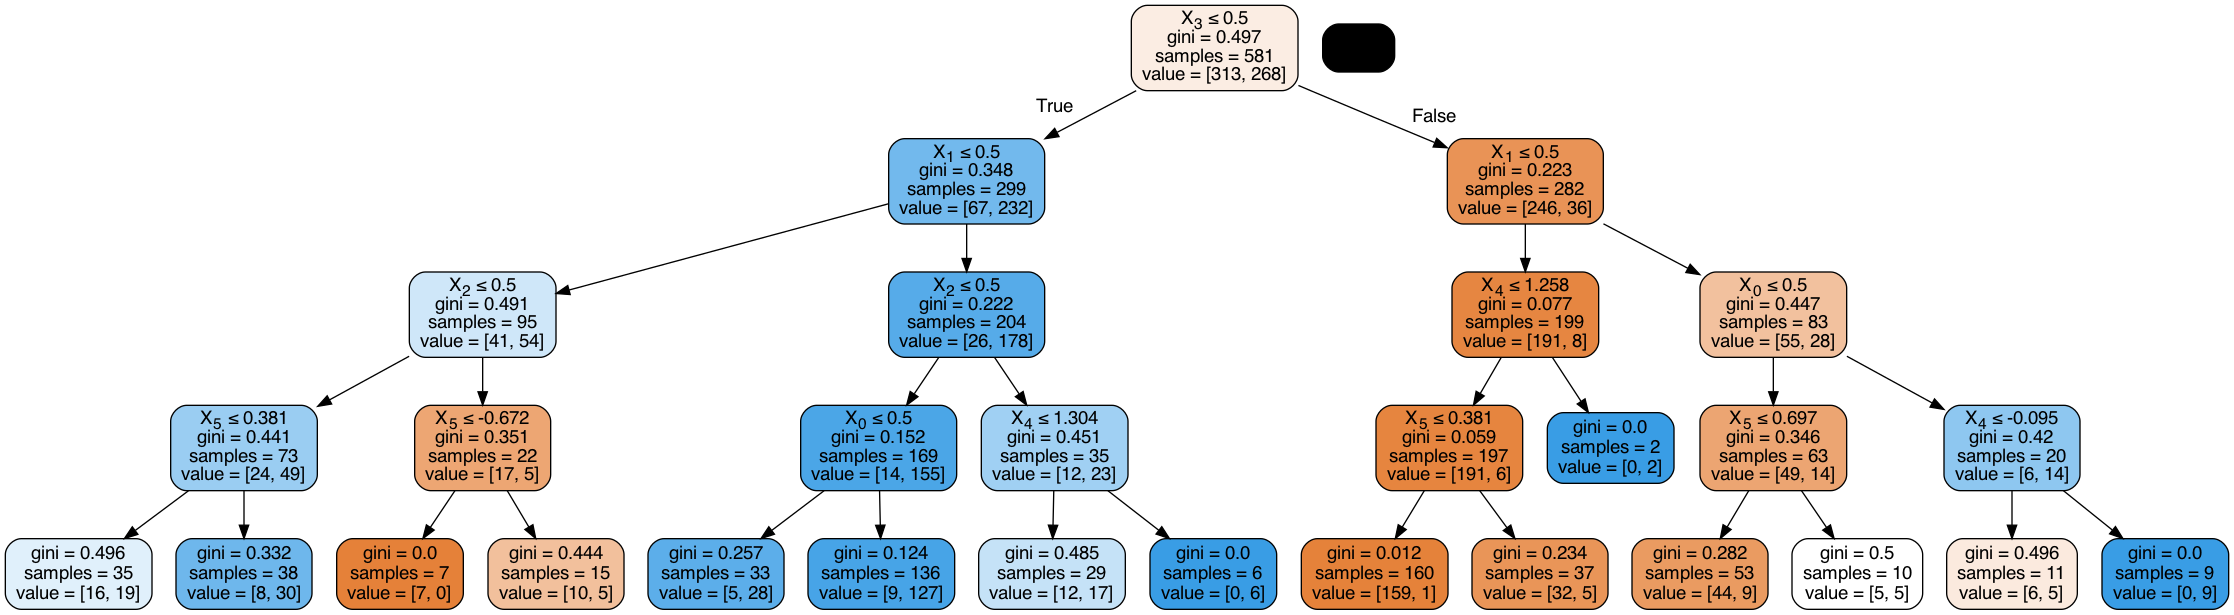

In [109]:
dot_data = StringIO()
export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [113]:
# Classification 2a notebook

def splitData(features):
    """Split a subset of the Heart Disease dataset, given by the features, into train and test sets."""
    HeartDisease_predictors = prepared[features].values
    HeartDisease_labels = prepared["HeartDisease"].values

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(HeartDisease_predictors, HeartDisease_labels, random_state=1, test_size=0.5)
    return XTrain, XTest, yTrain, yTest

In [114]:
# Classification 2a notebook

from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["HeartDisease", "Healthy"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

Accuracy on training data =  0.8484848484848485
Accuracy on test data =  0.8791208791208791


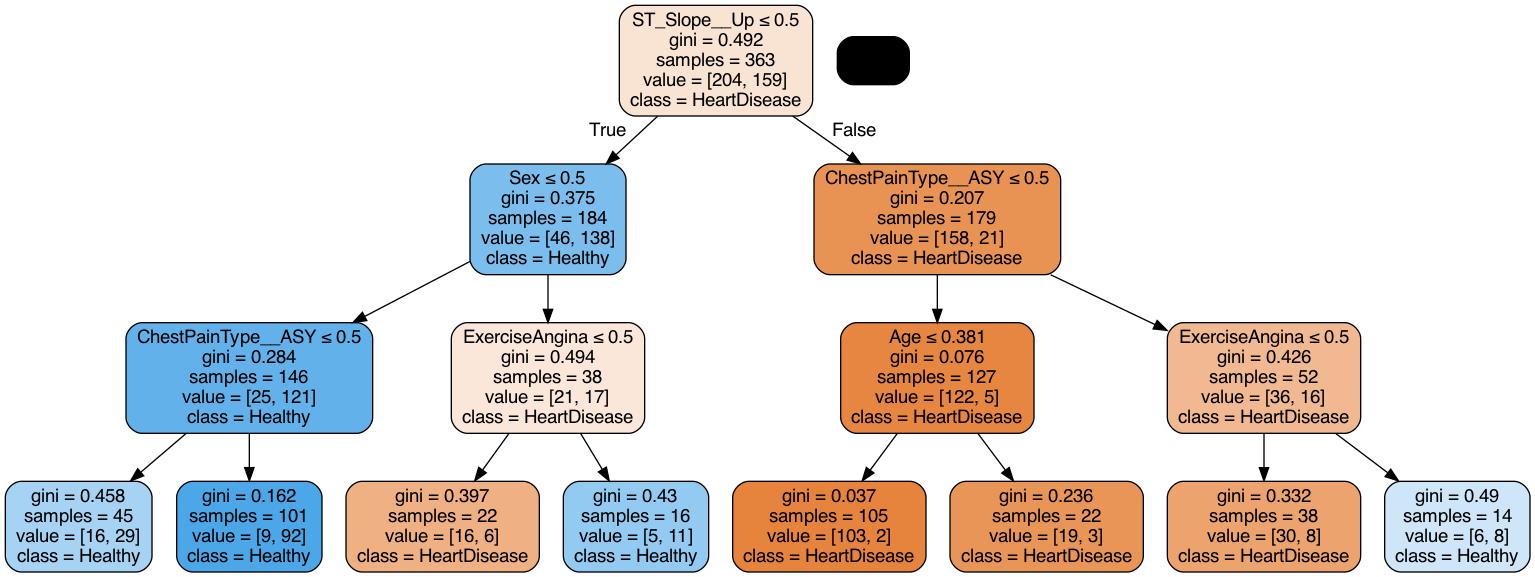

In [123]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

decisionTree = tree.DecisionTreeClassifier(max_depth=3)

used_features = ['ExerciseAngina','ChestPainType__ASY', 'Sex', 'ST_Slope__Up', 'Oldpeak', 'Age']
XTrain, XTest, yTrain, yTest = splitData(used_features)
# fit the tree with the traing data
decisionTree = decisionTree.fit(XTrain, yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(XTrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(XTest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

renderTree(decisionTree, used_features)

In [120]:
scores = cross_val_score(DecisionTreeClassifier(use_label_encoder =False, eval_metric='logloss'), prepared[selected['regularization']], prepared['HeartDisease'], scoring='recall', cv=10)

TypeError: __init__() got an unexpected keyword argument 'use_label_encoder'